In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
dataset_path = 'C:/Users/z004cfss/datasets/unity/digits_dataset'
plot_path = os.path.join(os.getcwd(), dataset_path.split("/")[-2])
imgHeight = 32
imgWidth = 32
epochs = 10
seed = 101

In [3]:
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

In [4]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (imgHeight, imgWidth))

    data.append(image)
    labels.append(label)

In [5]:
data = np.array(data)
labels = np.array(labels)

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [17]:
(trainX, validX, trainY, validY) = train_test_split(data, labels,            
                                                    random_state=seed,
                                                    stratify=labels,
                                                    test_size=0.25)

In [10]:
trainAug = ImageDataGenerator(rotation_range=30, zoom_range=0.15, 
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.15,
                              horizontal_flip=True,
                              fill_mode="nearest")
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [11]:
baseModel = VGG16(weights="imagenet", include_top=False, 
                  input_tensor=Input(shape=(imgHeight, imgWidth, 3)))
for layer in baseModel.layers:
    layer.trainable = False

    print("[INFO] summary for base model...")
print(baseModel.summary())

[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
[INFO] summary for base model...
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
____________________________

In [12]:
headModel = baseModel.output
headModel = Flatten(name='faletten')(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [13]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [26]:
learning_rate = 1e-3
batch_size = 32
optimizer = Adam(learning_rate=learning_rate)

In [27]:
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [28]:
print("[INFO] training head...")
history = model.fit(x=trainAug.flow(trainX, trainY, batch_size=batch_size),
                    steps_per_epoch=len(trainX)//batch_size,
                    validation_data=valAug.flow(validX, validY),
                    validation_steps=len(validX)//batch_size,
                    epochs=epochs)

[INFO] training head...
Epoch 1/10
4/4 [==============================] - 1s 109ms/step - loss: 8.2809 - accuracy: 0.6263 - val_loss: 3.6888 - val_accuracy: 0.5312
Epoch 2/10
4/4 [==============================] - 0s 78ms/step - loss: 6.6558 - accuracy: 0.6667 - val_loss: 5.2221 - val_accuracy: 0.4688
Epoch 3/10
4/4 [==============================] - 0s 68ms/step - loss: 4.9910 - accuracy: 0.7071 - val_loss: 4.5415 - val_accuracy: 0.4688
Epoch 4/10
4/4 [==============================] - 0s 82ms/step - loss: 3.5480 - accuracy: 0.7980 - val_loss: 4.6294 - val_accuracy: 0.6875
Epoch 5/10
4/4 [==============================] - 0s 83ms/step - loss: 4.1171 - accuracy: 0.7980 - val_loss: 3.9408 - val_accuracy: 0.6875
Epoch 6/10
4/4 [==============================] - 0s 73ms/step - loss: 3.6890 - accuracy: 0.7980 - val_loss: 3.3993 - val_accuracy: 0.7500
Epoch 7/10
4/4 [==============================] - 0s 86ms/step - loss: 4.4048 - accuracy: 0.7374 - val_loss: 3.3839 - val_accuracy: 0.7500
Ep

In [29]:
print("[INFO] evaluating network...")
predictions = model.predict(x=validX.astype("float32"), 
                            batch_size=batch_size)

print(classification_report(validY.argmax(axis=1), 
                            predictions.argmax(axis=1), 
                            target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

      digits       0.87      0.83      0.85        24
   no-digits       0.81      0.85      0.83        20

    accuracy                           0.84        44
   macro avg       0.84      0.84      0.84        44
weighted avg       0.84      0.84      0.84        44



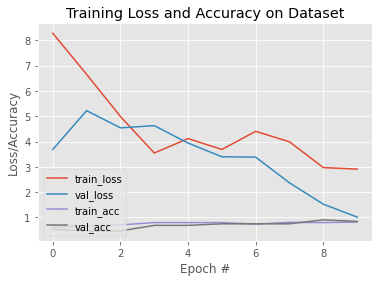

In [30]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot_path)

In [32]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [33]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk
